In [1]:
using Pkg: @pkg_str
pkg"activate  ."


In [2]:
using MLDatasets
using Plots
using MLDataUtils

using TensorFlow
using TensorFlow: summary

using Statistics

┌ Info: Recompiling stale cache file /Users/oxinabox/.julia/compiled/v1.1/MLDatasets/9CUQK.ji for MLDatasets [eb30cadb-4394-5ae3-aed4-317e484a6458]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/oxinabox/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/oxinabox/.julia/compiled/v1.1/MLDataUtils/CQWB9.ji for MLDataUtils [cc2ba9b6-d476-5e6d-8eaf-a92d5412d41d]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/oxinabox/.julia/compiled/v1.1/TensorFlow/IhIhf.ji for TensorFlow [1d978283-2c37-5f34-9a8e-e9c0ece82495]
└ @ Base loading.jl:1184
┌ Warning: Loading a new version of TensorFlow.jl for the first time. This initial load can take around 5 minutes as code is precompiled; subsequent usage will only take a few seconds.
└ @ TensorFlow ~/Documents/oxinabox.github.io/_drafts/JuliaDeepLearningMeetupLondon2019/dev/TensorFlow/src/TensorFlow.jl:3


## Network Definition

In [223]:
sess = Session(Graph())

leaky_relu6(x) = 0.01x + nn.relu6(x)

# Network Definition
@tf begin
    X = placeholder(Float32, shape=[-1, 28*28])
    
    # Network parameters
    hl_sizes = [512, 128, 64, 2, 64, 128, 512]

    Zs = [X]
    for (ii, hlsize) in enumerate(hl_sizes)
        Wii = get_variable("W_$ii", [get_shape(Zs[end], 2), hlsize], Float32)
        bii = get_variable("b_$ii", [hlsize], Float32)
        Zii = leaky_relu6(Zs[end]*Wii + bii)
        push!(Zs, Zii)
    end
    
    Wout = get_variable([get_shape(Zs[end], 2), 28*28], Float32)
    bout = get_variable([28*28], Float32)
    Y = nn.sigmoid(Zs[end]*Wout + bout)
    
    
    Z_code = Zs[end÷2 + 1] # A name for the coding layer
    @assert get_shape(Z_code,2) == 2
end

losses = 0.5(Y .- X).^2
loss = reduce_mean(losses) + 0.01reduce_mean(bout.^2)
optimizer = train.minimize(train.AdamOptimizer(), loss)

<Tensor Group:1 shape=() dtype=Any>

## Visualisation Code

In [224]:

function one_image(img::Vector, frames_image_res=30)
    ret = zeros((frames_image_res, frames_image_res))
    ret[2:end-1, 2:end-1] = 1 .- rotl90(reshape(img, (28,28)))
    ret
end

function scatter_image(images, res; frames_image_res=30, no_overlap=false)
    canvas = ones(res, res)
    images = reshape(images, (28*28, :));
    codes = run(sess, Z_code, Dict(X=>images'))
    for ii in 1:2
        codes[:,ii] = (codes[:,ii] .- minimum(codes[:,ii]))./(maximum(codes[:,ii])-minimum(codes[:,ii]))
        @assert(minimum(codes[:,ii]) >= 0.0)
        @assert(maximum(codes[:,ii]) <= 1.0)
    end
    
    function target_area(code)
        central_res = res-frames_image_res-1
        border_offset = frames_image_res/2 + 1
        x,y = code*central_res .+ border_offset
        
        get_pos(v) = round(Int, v-frames_image_res/2)
        x_min = get_pos(x)
        x_max = x_min + frames_image_res-1
        y_min =  get_pos(y)
        y_max = y_min + frames_image_res-1
        
        @view canvas[x_min:x_max, y_min:y_max]
    end
    
    for ii in 1:size(codes, 1)
        code = codes[ii,:]
        img = images[:,ii]
        area = target_area(code)        
        no_overlap && any(area.<1) && continue # Don't draw over anything
        area[:] = one_image(img, frames_image_res)
    end
    canvas
end


function demo_plot()
    code_plt = scatter_image(test_images[:,:,1:100], 700)

    src_images = Float32.(test_images[:,:,6:7])
    src1 = one_image(vec(src_images[:,:,1]))
    src2 = one_image(vec(src_images[:,:,2]))

    dst_vecs = run(sess, sess.graph["Y"], Dict(X=>reshape(src_images, :, 28*28)))
    
    dst1 = one_image(dst_vecs[1,:])
    dst2 = one_image(dst_vecs[2,:])

    plot(
        heatmap(code_plt),
        plot(heatmap(src1), heatmap(dst1); layout=grid(2,1)),
        plot(heatmap(src2), heatmap(dst2); layout=grid(2,1));
        axis=false, colorbar=false,
        layout=grid(1,3; widths=(0.7,0.15, 0.15))
    )
end

demo_plot (generic function with 1 method)

# Training Code

In [225]:
train_images = MNIST.traintensor()
test_images = MNIST.testtensor();

In [226]:
train_images

28×28×60000 reinterpret(FixedPointNumbers.Normed{UInt8,8}, ::Array{UInt8,3}):
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0    0.0    …  0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.216  0.533  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0    …  0.0    0.675  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.071  0.886  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.671  0.992  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.118     0.859  0.992  0.831  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.141     0.992  0.992  0.529  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.369  …  0.992  0.992  0.518  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.604     0.992  0.

In [227]:
train_images_flat = Float32.(reshape(train_images, (28*28, :)))
train_images_flat

784×60000 Array{Float32,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [235]:
run(sess, global_variables_initializer())

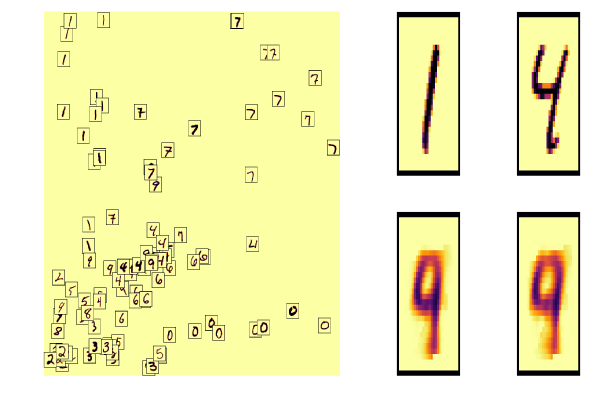

Epoch: 50, Batch 51 loss: 0.019509320283419212


In [236]:
auto_loss = Float64[]

for epoch in 1:50
    epoch_loss = Float64[]
    
    train_obs = shuffleobs(train_images_flat, ObsDim.Last())
    batches = eachbatch(train_images_flat, 1_000, ObsDim.Last())
    for (batch_ii, batch_x) in  enumerate(batches)
        loss_o, _ = run(sess, (loss, optimizer), Dict(X=>batch_x'))
        push!(epoch_loss, loss_o)
        
        if batch_ii % 10 == 1 
            println("Epoch: $epoch, Batch $batch_ii loss: $(loss_o)")
            display(demo_plot())
            IJulia.clear_output(true)
        end
    end
end

In [ ]:
# Create a summary writer
sess= Session(Graph())

@tf begin
    x = placeholder(Float64)
    y = sin(x)
end

@show y

run(sess, y, Dict(x=>0.5))
summary_writer = TensorFlow.summary.FileWriter(mkpath("logs"); graph=sess.graph)
x_summary = TensorFlow.summary.scalar("x", x)
y_summary = TensorFlow.summary.scalar("y", y)

merged_summary_op = TensorFlow.summary.merge_all()

for (ii, x_val) in enumerate(-1:0.1:1)
    y_val, summaries = run(sess, [y, merged_summary_op], Dict(x=>x_val))
    write(summary_writer, summaries,  ii)
end
